# Seattle Crime
Like all big cities, Seattle has areas and neighborhoods that feel safer or less safe than others.  Personally, I know I have ideas about where I should be on my guard at night, neighborhoods where I should not park my car for extended periods of time, and areas that are not safe to buy a house in.  Are these ideas I have correct?  Do some neighborhoods and areas in Seattle really have more crime than others?  Fortunately there is no need to speculate anymore - we have data!  In particular, the Seattle Police Department uploads initial police reports to a publically accessible dataset 6-12 hours after responding to an incident.  This data set includes information regarding location, time, and a summary of the offense description.

In this study we will study whether different neighborhoods in Seattle have different levels of crime.

We will use data from the Seattle Police API.  You can find all the details here:

https://data.seattle.gov/Public-Safety/Seattle-Police-Department-Police-Report-Incident/7ais-f98f

We start this project by loading all of the required packages for this project.

(Side note - you can find all of this code in my GitHub:  https://github.com/JTDean123)

In [790]:
import urllib.request
import json
import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import Image
from sklearn.decomposition import PCA
from sklearn.preprocessing import scale
import numpy as np
from sklearn.cluster import KMeans
from random import randint
from sklearn.datasets import load_digits

Next we import the most recent crime data and convert it to a pandas data frame.  

In [128]:
# Data was pulled on March 17, 2017 at 10AM
crime2017 = urllib.request.urlopen('https://data.seattle.gov/resource/policereport.json')
crime2017 = pd.read_json(crime2017)
crime2017.head(3)

,census_tract_2000,date_reported,district_sector,general_offense_number,hundred_block_location,latitude,location,longitude,month,occurred_date_or_date_range_start,occurred_date_range_end,offense_code,offense_code_extension,offense_type,rms_cdw_id,summarized_offense_description,summary_offense_code,year,zone_beat
0,7300.1029,2017-03-18T06:31:00,D,201795658,12XX BLOCK OF THOMAS ST,47.620815,"{'latitude': '47.620815277', 'needs_recoding':...",-122.332344,3,2017-03-18T04:56:00,NaN,X,21,DISTURBANCE-OTH,1154709,DISTURBANCE,X,2017,D3
1,11102.4008,2017-03-18T03:21:00,S,201795614,77XX BLOCK OF RAINIER AV S,47.533142,"{'latitude': '47.53314209', 'needs_recoding': ...",-122.269989,3,2017-03-18T03:21:00,NaN,5707,0,TRESPASS,1154704,TRESPASS,5700,2017,S2
2,9300.3029,2017-03-18T02:13:00,O,201795555,1XX BLOCK OF S HANFORD ST,47.575577,"{'latitude': '47.575576782', 'needs_recoding':...",-122.333740,3,2017-03-18T02:13:00,NaN,5499,0,TRAFFIC,1154683,TRAFFIC,5400,2017,O2


Looking good.  Now that the crime data has been converted into a data frame let's check out the dimensions.

In [555]:
crime2017.shape

(1000, 6)

As mentioned in the Seattle Police API documentation, there are 19 features in this data set.  Also, there are 1000 observations, the throttling limit for this API. A large number of these features will not be very useful for this project, so we will next create a new data frame containing those that we need moving forward.  Specifically, we will keep:

* district_sector
* latitude
* longitude
* month
* summarized_offense_description
* zone_beat

and we can slice our data frame to include only these.

In [560]:
crime2017 = crime2017[['district_sector', 'latitude', 'longitude', 'month', 'summarized_offense_description', 'zone_beat']]
crime2017.head(3)

,district_sector,latitude,longitude,month,summarized_offense_description,zone_beat
0,D,47.620815,-122.332344,3,DISTURBANCE,D3
1,S,47.533142,-122.269989,3,TRESPASS,S2
2,O,47.575577,-122.333740,3,TRAFFIC,O2


The next step is to check the data frame for missing data.  We first scan the entire data frame to determine if any data is missing.

In [561]:
crime2017.isnull().values.any()

False

Great-  No missing data!  The Seattle Police Department has provided us a clean data set.  Next, we take a look at the summarized_offense_description feature to see what types of offenses and how many exist in the data.  We will use 'value_counts( )' and convert the result to a DataFame.

In [562]:
crimeTypes = crime2017['summarized_offense_description'].value_counts()
crimeTypes = pd.DataFrame(crimeTypes)

Now we can visualize the data with a barplot.

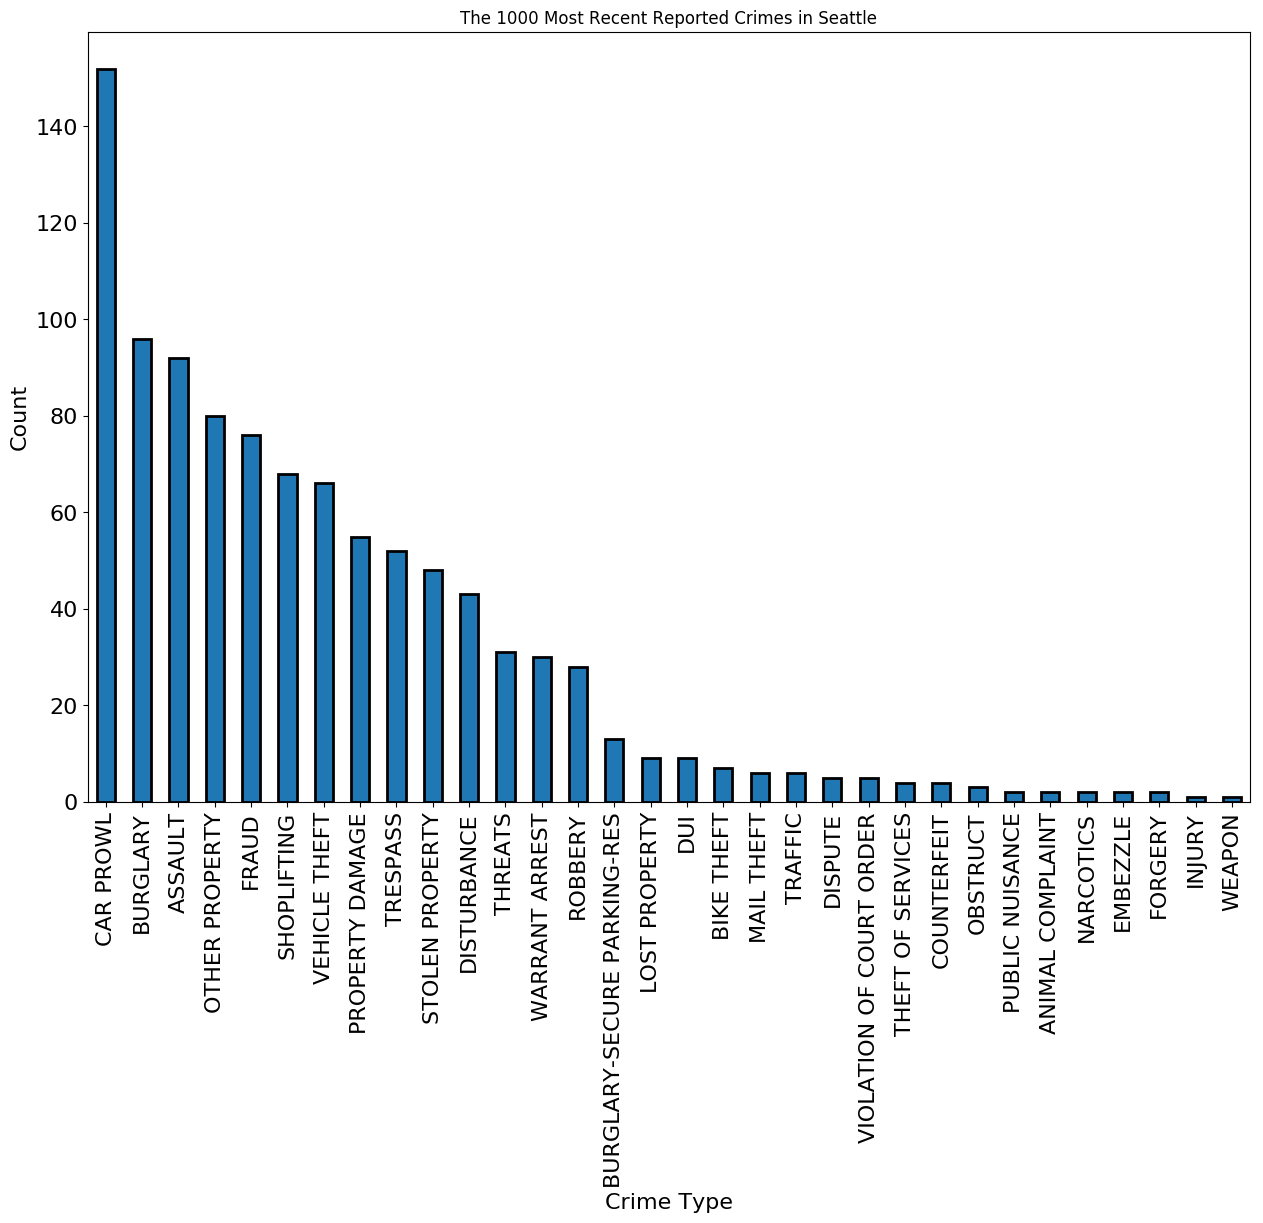

In [563]:
plot = crimeTypes.plot(kind='bar', title='The 1000 Most Recent Reported Crimes in Seattle', figsize=(15, 10), legend=False, fontsize=16, edgecolor = 'black', linewidth=2);
plot.set_ylabel('Count', fontsize=16)
plot.set_xlabel('Crime Type', fontsize=16)
plt.show()

Interestingly, we find that the crime incident that is report most in this data set is car prowling.  This makes sense, as finding broken car window glass on curbs is a pretty common thing around town.  The corresponding district_sector is also included in this data set, and we can use this to determine the locations of these observations.  As described here - 

https://www.seattle.gov/police/about-us/about-policing/precinct-and-patrol-boundaries

and shown in map form here -

https://www.seattle.gov/police/information-and-data/tweets-by-beat

Seattle is divided into 17 sectors (letters) and each sector is divided into beats (numbers).  This is visualized below.

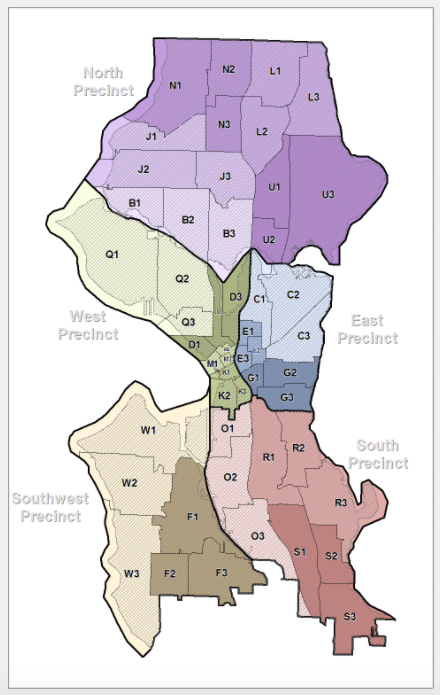

In [434]:
Image("seattleMap.png")

We can start by determining the amount of crimes reported in each sector.

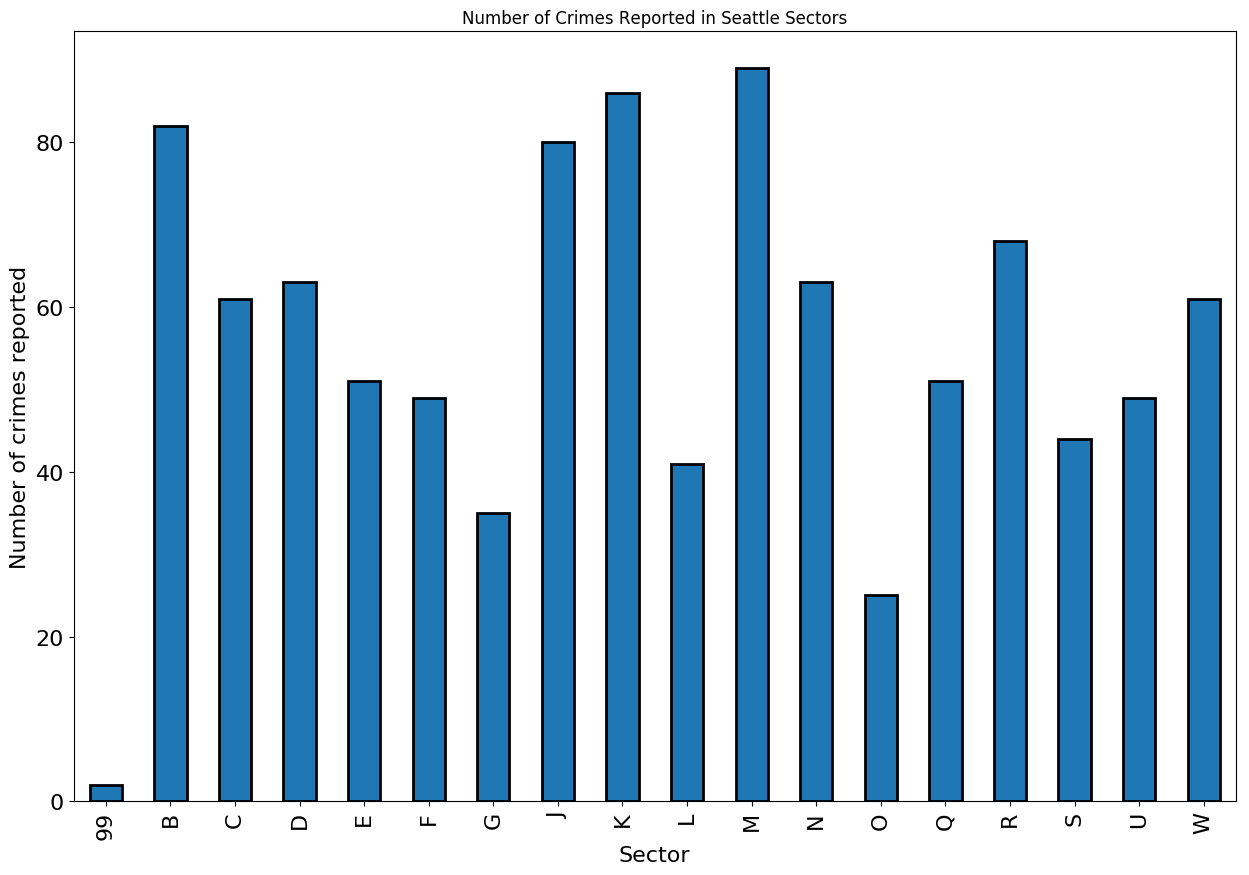

In [564]:
district_sector = crime2017.groupby('district_sector')['month'].count()
district_sector = pd.DataFrame(district_sector)

plot = district_sector.plot(kind='bar', title='Number of Crimes Reported in Seattle Sectors', figsize=(15, 10), legend=False, fontsize=16, edgecolor = 'black', linewidth=2);
plot.set_ylabel('Number of crimes reported', fontsize=16)
plot.set_xlabel('Sector', fontsize=16)
plt.show()

The four sectors with the highest number of crimes reported are, in descending order: 

* M - Downtown
* K - Downtown / Pioneer Square
* B - Ballard / Fremont
* J - Ballard / Greenlake

The neighborhood with the lowest number of reported crimes was O - Georgetown.

Disagree wth my neighborhood assignments?  Let me know! 

It is unclear what Sector '99' refers to. A quick search with the latitude/longitude data provided with this sector showed that these reports occurred inside the sector map shown above, so these may be data points with reporting errors for the location.  Regardless, the total number of counts for sector 99 was small, so I will remove these data points moving forward.

However, the number of reported crimes reported in each sector was much closer than I thought it would be.  It may be that boundaries are determined so that crimes are approximately evenly distributed between sectors.  

To further explore the relationship between crime and neighborhood location we can perform principal component analysis (PCA) on this data set.  PCA can be described at the eigendecomposition of a covariance matrix where the eigenvectors with the largest eigenvalues represent the most significant principal components. Thus, the largest principal component is the combination of variables that has the maximum variance.  PCA is useful for dimension reduction of large data sets and, more relevant for this example, determining the variables that explain most of the variance in the data set.  

So, a PCA of this data set will tell us what variables, or types of crimes, explain the variance in the neighborhoods, or sectors.  To begin, we need to build a data matrix that contains crime types in columns and sectors as rows.  Each entry will correspond to the number of crime types for a given sector, and we will remove sector 99 for the reasons mentioned above.

In [879]:
crimeArray = crime2017.groupby(['summarized_offense_description','district_sector'])['district_sector'].count().unstack()
crimeArray = crimeArray.drop('99', 1)
crimeArray = crimeArray.transpose()
crimeArray.head(5)

summarized_offense_description,ANIMAL COMPLAINT,ASSAULT,BIKE THEFT,BURGLARY,BURGLARY-SECURE PARKING-RES,CAR PROWL,COUNTERFEIT,DISPUTE,DISTURBANCE,DUI,...,SHOPLIFTING,STOLEN PROPERTY,THEFT OF SERVICES,THREATS,TRAFFIC,TRESPASS,VEHICLE THEFT,VIOLATION OF COURT ORDER,WARRANT ARREST,WEAPON
district_sector,,,,,,,,,,,,,,,,,,,,,
B,NaN,7.0,NaN,3.0,NaN,24.0,NaN,NaN,6.0,3.0,...,1.0,4.0,NaN,2.0,NaN,NaN,2.0,NaN,1.0,NaN
C,NaN,6.0,2.0,17.0,5.0,2.0,NaN,1.0,2.0,NaN,...,2.0,2.0,NaN,2.0,NaN,2.0,2.0,NaN,NaN,NaN
D,NaN,6.0,NaN,10.0,3.0,11.0,NaN,NaN,3.0,NaN,...,NaN,5.0,NaN,2.0,NaN,5.0,5.0,NaN,1.0,NaN
E,NaN,11.0,NaN,3.0,2.0,9.0,NaN,NaN,3.0,NaN,...,NaN,NaN,NaN,5.0,1.0,4.0,1.0,NaN,NaN,NaN
F,NaN,NaN,NaN,7.0,NaN,4.0,NaN,NaN,2.0,NaN,...,NaN,1.0,NaN,NaN,3.0,NaN,3.0,NaN,5.0,1.0


Looking at the data above, we can see some crime types are not reported in a particular sector.  For example, sector B does not have any Bike thefts, therefore we need to convert the NaN values to zero.

In [880]:
crimeArray = crimeArray.replace(np.nan, 0)
crimeArray.head(5)

summarized_offense_description,ANIMAL COMPLAINT,ASSAULT,BIKE THEFT,BURGLARY,BURGLARY-SECURE PARKING-RES,CAR PROWL,COUNTERFEIT,DISPUTE,DISTURBANCE,DUI,...,SHOPLIFTING,STOLEN PROPERTY,THEFT OF SERVICES,THREATS,TRAFFIC,TRESPASS,VEHICLE THEFT,VIOLATION OF COURT ORDER,WARRANT ARREST,WEAPON
district_sector,,,,,,,,,,,,,,,,,,,,,
B,0.0,7.0,0.0,3.0,0.0,24.0,0.0,0.0,6.0,3.0,...,1.0,4.0,0.0,2.0,0.0,0.0,2.0,0.0,1.0,0.0
C,0.0,6.0,2.0,17.0,5.0,2.0,0.0,1.0,2.0,0.0,...,2.0,2.0,0.0,2.0,0.0,2.0,2.0,0.0,0.0,0.0
D,0.0,6.0,0.0,10.0,3.0,11.0,0.0,0.0,3.0,0.0,...,0.0,5.0,0.0,2.0,0.0,5.0,5.0,0.0,1.0,0.0
E,0.0,11.0,0.0,3.0,2.0,9.0,0.0,0.0,3.0,0.0,...,0.0,0.0,0.0,5.0,1.0,4.0,1.0,0.0,0.0,0.0
F,0.0,0.0,0.0,7.0,0.0,4.0,0.0,0.0,2.0,0.0,...,0.0,1.0,0.0,0.0,3.0,0.0,3.0,0.0,5.0,1.0


Looking at the types of crimes that were reported, it seems that although 32 types of crimes are reported, they fall naturally into a smaller number of groups.  For example, 'Bike Theft' and 'Shoplifting' could be generally grouped at 'Theft'.  Therefore we will create new features from the crime types by grouping them as follows:
<br>
*  **Theft:**  
BIKE THEFT, BURGLARY, BURGLARY-SECURE PARKING-RES, CAR PROWL, MAIL THEFT, ROBBERY, SHOPLIFTING, STOLEN PROPERTY,      THEFT OF SERVICES, VEHICLE THEFT  
<br>
*  **Fraud:**  
COUNTERFEIT, EMBEZZLE, FORGERY, FRAUD  
<br>
*  **Violence:**  
ASSAULT, THREATS, WEAPON, INJURY  
<br>
*  **Drugs:**  
DUI, NARCOTICS  
<br> 
*  **Property:**  
LOST PROPERTY, OTHER PROPERTY, PROPERTY DAMAGE  
<br> 
*  **Court Violation:**  
VIOLATION OF COURT ORDER, WARRANT ARREST  
<br> 
*  **Public Offense:**  
DISPUTE, DISTURBANCE, OBSTRUCT, PUBLIC NUISANCE, TRESPASS  
<br> 

Note that we will leave ANIMAL COMPLAINT and TRAFFIC as their own categories as they do not naturally fall into one of the new categories listed above.  Using this grouping strategy we can reduce 32 features to 9.  This grouping is done as follows below.

In [881]:
crimeArray['Theft'] = crimeArray['BIKE THEFT'] + crimeArray['BURGLARY'] + crimeArray['BURGLARY-SECURE PARKING-RES'] + crimeArray['CAR PROWL'] + crimeArray['MAIL THEFT'] + crimeArray['ROBBERY'] + crimeArray['SHOPLIFTING'] + crimeArray['STOLEN PROPERTY'] + crimeArray['THEFT OF SERVICES']  + crimeArray['VEHICLE THEFT']  

crimeArray['Fraud'] = crimeArray['COUNTERFEIT'] + crimeArray['EMBEZZLE'] + crimeArray['FORGERY'] + crimeArray['FRAUD'] 

crimeArray['Violence'] = crimeArray['ASSAULT'] + crimeArray['THREATS'] + crimeArray['WEAPON'] + crimeArray['INJURY'] 

crimeArray['Drugs'] = crimeArray['DUI'] + crimeArray['NARCOTICS']

crimeArray['Property'] = crimeArray['LOST PROPERTY'] + crimeArray['OTHER PROPERTY'] + crimeArray['PROPERTY DAMAGE']

crimeArray['Court Violation'] = crimeArray['VIOLATION OF COURT ORDER'] + crimeArray['WARRANT ARREST']

crimeArray['Public Offense'] = crimeArray['DISPUTE'] + crimeArray['DISTURBANCE'] + crimeArray['OBSTRUCT'] + crimeArray['PUBLIC NUISANCE']  + crimeArray['TRESPASS']

crimeArray['Traffic'] = crimeArray['TRAFFIC']

crimeArray['Animal Complaint'] = crimeArray['ANIMAL COMPLAINT']

crimeArray = crimeArray.iloc[:,32:]
crimeArray.head(25)

summarized_offense_description,Theft,Fraud,Violence,Drugs,Property,Court Violation,Public Offense,Traffic,Animal Complaint
district_sector,,,,,,,,,
B,39.0,8.0,9.0,3.0,16.0,1.0,6.0,0.0,0.0
C,34.0,4.0,8.0,0.0,8.0,0.0,7.0,0.0,0.0
D,36.0,2.0,8.0,0.0,7.0,1.0,9.0,0.0,0.0
E,15.0,3.0,17.0,0.0,8.0,0.0,7.0,1.0,0.0
F,15.0,4.0,1.0,1.0,18.0,5.0,2.0,3.0,0.0
G,9.0,1.0,5.0,0.0,6.0,1.0,11.0,0.0,2.0
J,55.0,2.0,2.0,0.0,16.0,1.0,4.0,0.0,0.0
K,22.0,7.0,32.0,1.0,5.0,6.0,13.0,0.0,0.0
L,21.0,12.0,4.0,0.0,4.0,0.0,0.0,0.0,0.0


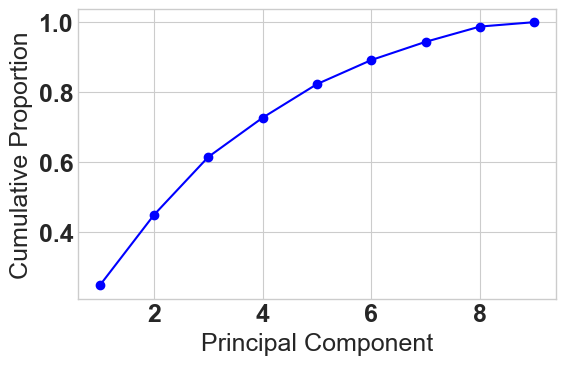

In [568]:
pca = PCA()
crimePCA = pca.fit(scale(crimeArray))
cumsum = crimePCA.explained_variance_ratio_.cumsum()

with plt.style.context('seaborn-whitegrid'):
    plt.figure(figsize=(6, 4))
    
    font = {'weight' : 'bold',
        'size'   : 18}
    
    plt.rc('font', **font)
    
    plt.plot(range(1,len(cumsum)+1), cumsum, '-o', color='b')
    plt.xlabel('Principal Component')
    plt.ylabel('Cumulative Proportion')    
    plt.tight_layout()
    plt.show()
    plt.rcdefaults()


As shown above, over 70% of the variation in the data is attributed to four principal components, and we can explore this further.

In [584]:
pcDF = pd.DataFrame(crimePCA.components_[0:4])
pcDF = pcDF.transpose()
pcDF.columns = ['PC1', 'PC2', 'PC3', 'PC4']
indexes = crimeArray.columns.tolist()
pcDF.index = [indexes]
pcDF

,PC1,PC2,PC3,PC4
Theft,-0.216239,-0.268253,-0.560047,-0.305941
Fraud,-0.178603,-0.509305,-0.054975,0.451431
Violence,-0.456637,-0.162421,0.387359,-0.208361
Drugs,0.117521,-0.479407,0.109732,0.530480
Property,0.427143,-0.182437,0.040754,-0.291975
Court Violation,-0.002167,-0.333201,0.477726,-0.414472
Public Offense,-0.533502,-0.018754,0.249167,-0.039958
Traffic,0.471814,-0.107496,0.377428,-0.015298
Animal Complaint,-0.096566,0.506185,0.294649,0.344847


We can now interpret these contributors to these principal components.  The value for each feature in each principal component, or loading, tells us how much the feature contributes to the principal component.  

For example, in PC1 we find a large negative value for Violence and a large positive value for Traffic.  This means that if a sector has a large negative PC1 it likely has high Violence and low Traffic crime types, and the opposite is true if a sector has a positive PC1.

* PC1 increases with traffic and property crime reports and decreases with violence and public offenses.  
<br> 
* PC2 decreases with fraud and drugs and increases with animal complaints.  
<br>  
* PC3 decreases with theft and increases with violence, court violations, and traffic crime reports.  
<br>  
* PC4 increases strongly with fraud and drug crime types.  
<br>  

It is interesting that although Violence and Drugs crime types are significant variables, indicating they explain much of the variance in the data set, they do not appear as large loading values in the same principal component, indicating that these two features do not vary together.  

We find that about 45% of the variance in the data set is captured in PC1 and PC2, and we can project the data on to this new feature space.  Including PC3 would capture over 60% of the variance, however this requires projecting and plotting in a 3D space, and I hate 3D plots!  

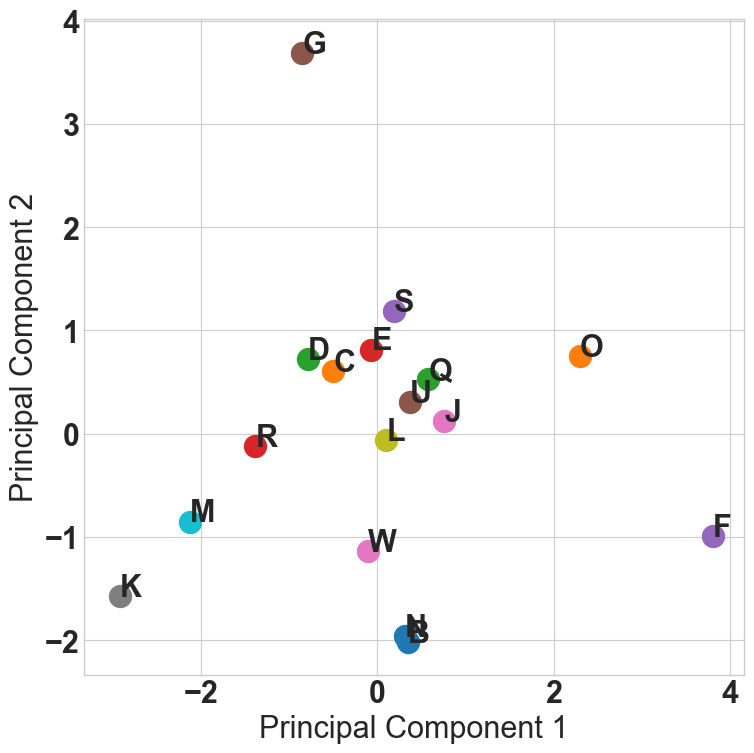

In [583]:
crimeProject = pca.fit_transform(scale(crimeArray))
sector = crimeArray.index.tolist()

with plt.style.context('seaborn-whitegrid'):
    plt.figure(figsize=(8, 8))
    
    font = {'weight' : 'bold',
        'size'   : 22}

    plt.rc('font', **font)
    
    for i, labels in enumerate(sector):
        plt.scatter(crimeProject[i,0], crimeProject[i,1], s=250)
        plt.annotate(labels, (crimeProject[i,0], crimeProject[i,1]))
    
    plt.xlabel('Principal Component 1')
    plt.ylabel('Principal Component 2') 
    plt.tight_layout()
    plt.show()
    plt.rcdefaults()
   

As mentioned above, we found that the two most significant variables in PC1 were Violence (negative) and Traffic crimes.  This indicates that a sector with a large negative PC1 likely has a high amount of violent crimes.  The two sectors with the largest negative PC1 are K (Downtown / Pioneer Square) and M (Downtown).  Additionally, sectors F (West Seattle) and O (Georgetown) have the largest positive PC1 values, indicating that these neighborhoods have high amounts of Traffic crimes and low Violent crimes.  

With regards to PC2, we find that sector G (Central District) had a significantly higher positive PC2 than the other sectors, indicating a large amount of Animal Complaint related crime reports.  This is because sector G was the only district with Animal Complaint crime reports, and it is unknown if this is a general feature of the Central District or if these were two random incidents without repeating this analysis at a later time.  You have the code - give it a try!  

It is tempting to try to cluster these sectors by eye, but unfortunately our intuition can be misleading so we need to use clustering strategies to determine which sectors group together.  To do this we will use the k-means algorithm.  The k-means clustering algorithm aims to cluster observations into k clusters in which each cluster has the nearest mean.  

To begin with clustering, we first need to manipulate the PCA result into the correct format by extracting the first two principal component values from each Sector.

In [861]:
crime2 = np.array(crimeProject[0,0:2])

for i in range(1,len(sector)):
    crime2 = np.vstack([crime2, crimeProject[i,0:2]])

We can now cluster the sectors in the five dimensional PC space.  At this point it is unknown how many clusters to use.  If we do not use enough we will not get good separation of sectors but if we use too many we will overfit the data and get meaningless clusters.  A good rule of thumb is to use a cluster number that minimizes the within-cluster sum of squares, or inertia.  Therefore we will perform k-means with a number of cluster numbers (1 to 17) and calculate the inertia as follows.

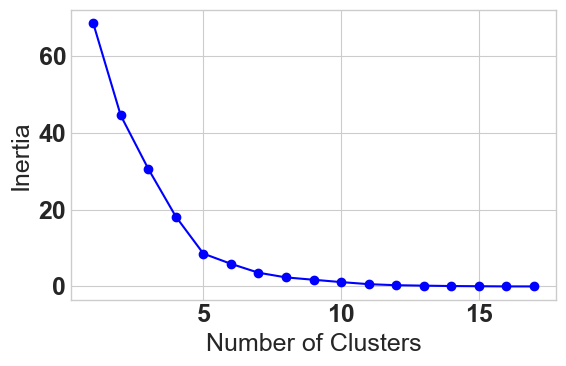

In [862]:
inertia = []
for i in range(1,18):
    kmeans = KMeans(n_clusters=i, random_state=123, n_init=10).fit(crime2)
    inertia.append(kmeans.inertia_)
    
with plt.style.context('seaborn-whitegrid'):
    plt.figure(figsize=(6, 4))
    
    font = {'weight' : 'bold',
        'size'   : 18}
    
    plt.rc('font', **font)
    
    plt.plot(range(1,18), inertia, '-o', color='b')
    plt.xlabel('Number of Clusters')
    plt.ylabel('Inertia')    
    plt.tight_layout()
    plt.show()
    plt.rcdefaults()

As shown above, we find that with 5 clusters we get close to the minimum inertia, and adding more clusters does not decrease the within cluster sum of squares substantially.  Next we perform k-means clustering with this optimal (disagree with 5?... let me know!) number of clusters and re-plot the sectors on the first two principal components.

First we perform k-means clustering with the optimal number of clusters.

In [863]:
optK = 5
kmeans = KMeans(n_clusters=optK, random_state=123, n_init=10).fit_predict(crime2)

Next we pick 5 random colors, one for each cluster.

In [779]:
colors = []
for i in range(optK):
    colors.append('#%06X' % randint(0, 0xFFFFFF))

And finally we plot the clustered sectors with k-means cluster boundaries. 

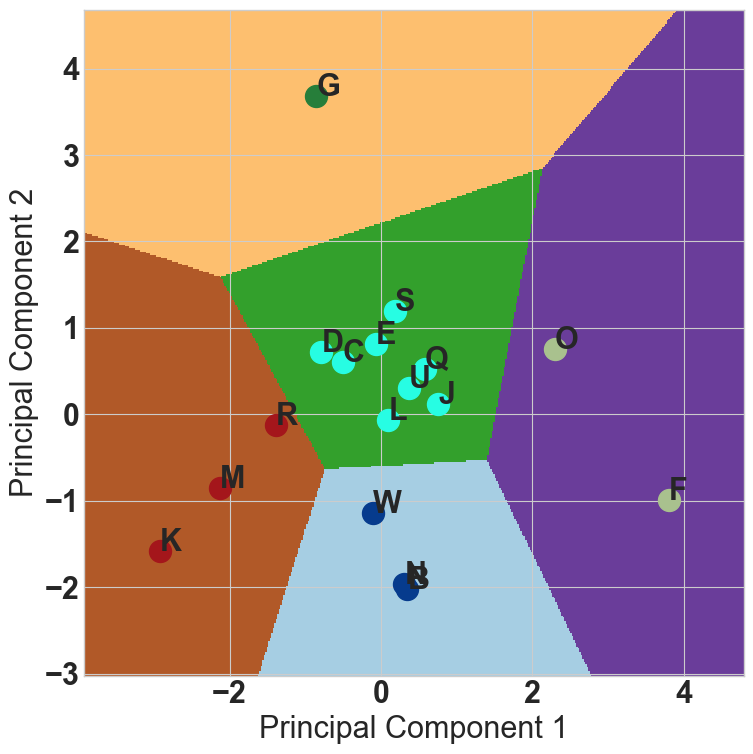

In [865]:
kcolors = []    
for i in kmeans:
    kcolors.append(colors[i])

h = .02
x_min, x_max = crime2[:, 0].min() - 1, crime2[:, 0].max() + 1
y_min, y_max = crime2[:, 1].min() - 1, crime2[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))

kmesh = KMeans(n_clusters=optK, random_state=123, n_init=10)
kmesh.fit(crime2)

kmeshPredict = kmesh.predict(np.c_[xx.ravel(), yy.ravel()])
kmeshPredict = kmeshPredict.reshape(xx.shape)
    
with plt.style.context('seaborn-whitegrid'):
    plt.figure(figsize=(8, 8))
    
    font = {'weight' : 'bold',
            'size'   : 22}

    plt.rc('font', **font)
        
    plt.imshow(kmeshPredict, interpolation='nearest',
               extent=(xx.min(), xx.max(), yy.min(), yy.max()),
               cmap=plt.cm.Paired, aspect='auto', origin='lower')
    
    for i, labels in enumerate(sector):
        plt.scatter(crime2[i,0], crime2[i,1], s=250, color=kcolors[i])
        plt.annotate(labels, (crime2[i,0], crime2[i,1]))
    
    plt.xlabel('Principal Component 1')
    plt.ylabel('Principal Component 2') 
    plt.tight_layout()
    plt.show()
    plt.rcdefaults()

As shown above, we find that the following sectors cluster together.  

**Cluster 1 - negative PC1 and PC2: high violent crimes and drugs**
* K - Pioneer Square
* M - Downtown
* R - Ranier Beach

**Cluster 2 - high PC2: high animal complaints**
* G - Central District 

**Cluster 3 - high PC1: high traffic and property crimes, low violence**
* O - West Georgetown
* F - East Georgetown

**Cluster 4 - negative PC2, PC1 = 0: low violence, traffic, and property crimes, high drug crimes**
* W - West Seattle
* N - Greenwood
* B - Ballard / Fremont

**Cluster 5 - low PC1 and PC2: low violent and drug crimes**
* D - South Lake Union
* C - Madison Valley / North Capitol Hill
* E - Capitol Hill
* S - Beacon Hill
* L - Lake City
* U - University District / Olympic Hills
* Q - Magnolia
* J - Green Lake  

As we found above, we can use the loading values of principal components to understand what types of crime explain the variation in the crime for a sector.  

Interestingly we find that Pioneer Square, Downtown, and Ranier Beach, neighborhoods that are often associated with crime, actually do seem to be characterized by violent crime and drugs.  Also, we found that the Georgetown neighborhoods are characterized by high traffic crimes, and this makes sense as there are not as many traffic lights or traffic as the surrounding neighborhoods and this could encourage speeding.  Finally, we find that West Seattle, Greenwood, and Ballard / Fremont cluster as neighborhoods with high drug crimes, and this goes against intuition.  These results do show, however, that certain neighborhoods, and areas, seem to be associated with different types of crime.   

Finally, we can visualize the crime data using Tableau.  We will go back to the original crime data frame containing the latitude / longitude data and group crimes as before.

In [905]:
import warnings
warnings.filterwarnings('ignore')
crimeLocs = crime2017.copy()

Theft = ['BIKE THEFT', 'BURGLARY', 'BURGLARY-SECURE PARKING-RES', 'CAR PROWL', 'MAIL THEFT', 'ROBBERY', 'SHOPLIFTING', 'STOLEN PROPERTY', 'THEFT OF SERVICES', 'VEHICLE THEFT']  

Fraud = ['COUNTERFEIT', 'EMBEZZLE', 'FORGERY', 'FRAUD'] 

Violence = ['ASSAULT', 'THREATS', 'WEAPON', 'INJURY'] 

Drugs = ['DUI', 'NARCOTICS']

Property = ['LOST PROPERTY', 'OTHER PROPERTY', 'PROPERTY DAMAGE']

CourtViolation = ['VIOLATION OF COURT ORDER', 'WARRANT ARREST']

PublicOffense = ['DISPUTE', 'DISTURBANCE', 'OBSTRUCT', 'PUBLIC NUISANCE', 'TRESPASS']


for i, crime in enumerate(crimeLocs['summarized_offense_description']):
    if crime in Theft:
        crimeLocs['summarized_offense_description'][i] = 'Theft'
        
    elif crime in Fraud:
        crimeLocs['summarized_offense_description'][i] = 'Fraud'
        
    elif crime in Violence:
        crimeLocs['summarized_offense_description'][i] = 'Violence'
        
    elif crime in Drugs:
        crimeLocs['summarized_offense_description'][i] = 'Drugs'  
        
    elif crime in Property:
        crimeLocs['summarized_offense_description'][i] = 'Property'
        
    elif crime in CourtViolation:
        crimeLocs['summarized_offense_description'][i] = 'Court Violation' 
        
    elif crime in PublicOffense:
        crimeLocs['summarized_offense_description'][i] = 'Public Offense'

crimeLocs.head()

,district_sector,latitude,longitude,month,summarized_offense_description,zone_beat
0,D,47.620815,-122.332344,3,Public Offense,D3
1,S,47.533142,-122.269989,3,Public Offense,S2
2,O,47.575577,-122.333740,3,TRAFFIC,O2
3,F,47.526882,-122.320274,3,Court Violation,F3
4,C,47.623684,-122.314644,3,Violence,C1


Next, we export this data to a csv file for analysis and visualization in Tableau.

In [907]:
crimeLocs.to_csv('CrimeLocs.csv')

We first visualize the crime incidents by type and location.

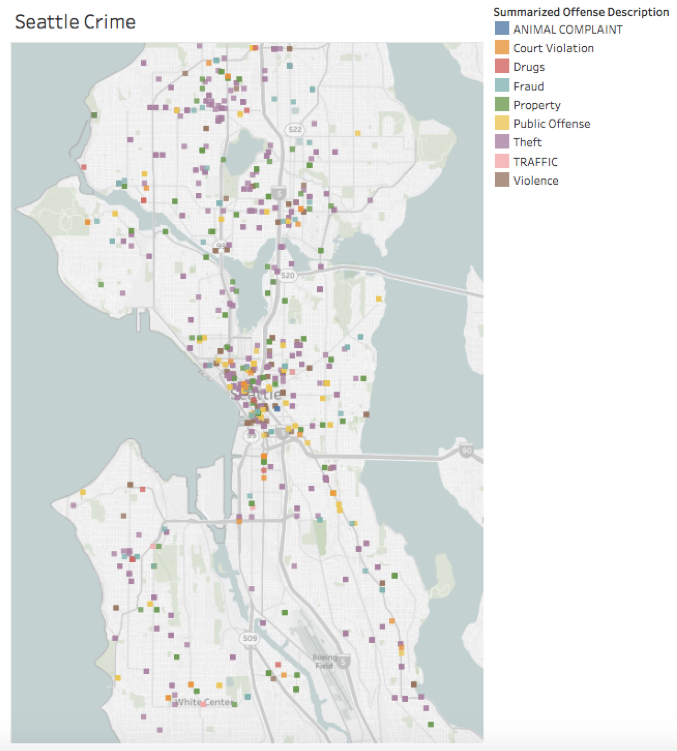

In [908]:
Image("seattleCrimeLocs.png")

And finally we can visualize violent and non-violent crimes in Seattle by location.

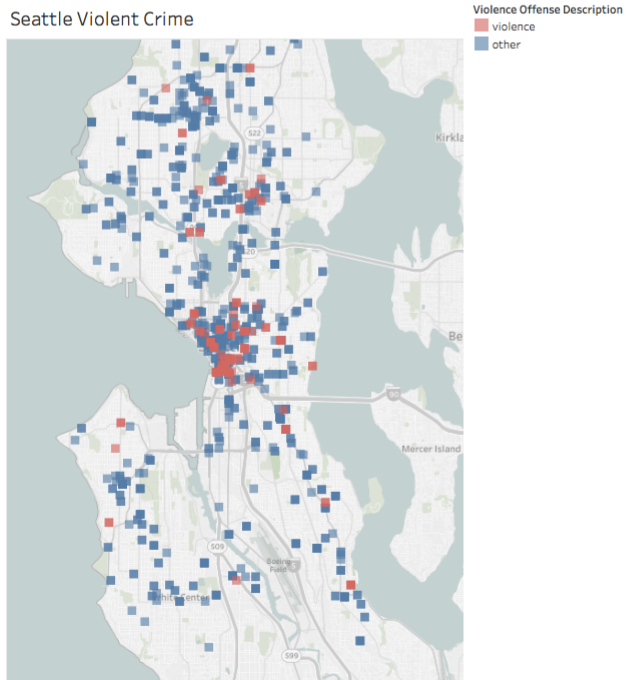

In [909]:
Image("seattleCrimeLocs2.png")

Just as we found above, the Downtown and Pioneer Square areas have a much greater density of violent crime.

Comments or suggestions for me?  Shoot me an email - http://jasontdean.com/contactinfo.php